<a href="https://colab.research.google.com/github/Daniel-Sottovia/PayFace_Daniel/blob/main/VGG16_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG16

## Data Preparation

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Vamos dividir os dados em 3 grupos: **train**, **valid** e **test**:


*   **train**: 1000 imagens
*   **valid**: 200 imagens
*   **test**: 100 imagens



In [ ]:
# Organize data into train, valid, test dirs
os.chdir('/content/drive/MyDrive/Liveness_Daniel/CNN/msu')
if os.path.isdir('train') is False:
  os.makedirs('train/attack')
  os.makedirs('train/real')
  os.makedirs('valid/attack')
  os.makedirs('valid/real')
  os.makedirs('test/attack')
  os.makedirs('test/real')

  for c in random.sample(glob.glob('attack-imgs/attack*'), 500):
    shutil.move(c, 'train/attack')  
  for c in random.sample(glob.glob('real-imgs/real*'), 500):
    shutil.move(c, 'train/real')
  for c in random.sample(glob.glob('attack-imgs/attack*'), 100):
    shutil.move(c, 'valid/attack')  
  for c in random.sample(glob.glob('real-imgs/real*'), 100):
    shutil.move(c, 'valid/real')
  for c in random.sample(glob.glob('attack-imgs/attack*'), 50):
    shutil.move(c, 'test/attack')  
  for c in random.sample(glob.glob('real-imgs/real*'), 50):
    shutil.move(c, 'test/real')

os.chdir('../../')

In [2]:
train_path = '/content/drive/MyDrive/Liveness_Daniel/CNN/msu/train'
valid_path = '/content/drive/MyDrive/Liveness_Daniel/CNN/msu/valid'
test_path = '/content/drive/MyDrive/Liveness_Daniel/CNN/msu/test'

In [3]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['attack','real'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['attack','real'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['attack','real'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [4]:
imgs, labels = next(train_batches)

In [5]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1,10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

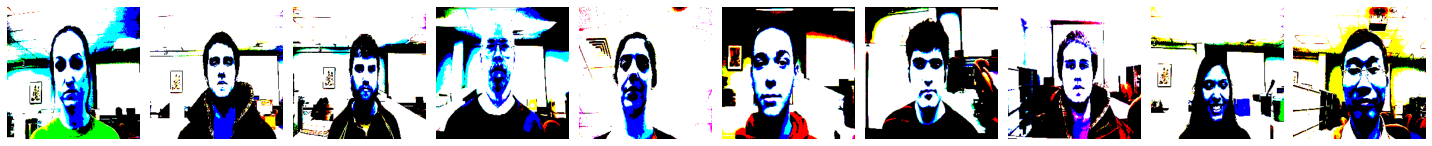

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [6]:
plotImages(imgs)
print(labels)

## Build Fine-tuned VGG16 model

In [7]:
# Dowload model - Internet connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 4s 0us/step


In [8]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
type(vgg16_model)

keras.engine.functional.Functional

In [10]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

A seguir iremos setar quais camadas serão treinadas e quais não serão.

In [12]:
cont = 0
for layer in model.layers:
  layer.trainable = False
  cont += 1
  if cont >= 17:
    break

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [14]:
model.add(Dense(units=2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

## Train the fine-tuned VGG16 model

Há modificações a se fazer sobre as **metrics** a serem usada e o modelo de **loss**

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Demorou 56 minutos para fazer o treinamento.

In [17]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 672s - loss: 0.1919 - accuracy: 0.9740 - val_loss: 7.6094e-05 - val_accuracy: 1.0000 - 672s/epoch - 7s/step
Epoch 2/5
100/100 - 640s - loss: 2.9802e-08 - accuracy: 1.0000 - val_loss: 8.0780e-05 - val_accuracy: 1.0000 - 640s/epoch - 6s/step
Epoch 3/5
100/100 - 641s - loss: 1.9431e-08 - accuracy: 1.0000 - val_loss: 8.3828e-05 - val_accuracy: 1.0000 - 641s/epoch - 6s/step
Epoch 4/5
100/100 - 641s - loss: 1.5259e-08 - accuracy: 1.0000 - val_loss: 8.8967e-05 - val_accuracy: 1.0000 - 641s/epoch - 6s/step
Epoch 5/5
100/100 - 636s - loss: 1.2755e-08 - accuracy: 1.0000 - val_loss: 8.9820e-05 - val_accuracy: 1.0000 - 636s/epoch - 6s/step


## Predict using fine-tuned VGG16 model

In [24]:
predictions = model.predict(x=test_batches, verbose=0)

In [25]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [26]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [27]:
test_batches.class_indices

{'attack': 0, 'real': 1}

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Pelo que entendi acertou todos os testes.

Confusion matrix, without normalization
[[50  0]
 [ 0 50]]


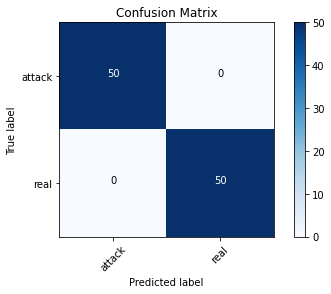

In [30]:
cm_plot_labels = ['attack', 'real']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')